# Нейронна мережа для класифікації зображень
- тип - згорткова
- датасет для навчання - CIFAR-10 (60000 кольорових зображень розміром 32x32, розбитих на 10 класів по 6000 прикладів на клас)
- класифікація відбувається по класах: airplane, car, bird, cat, deer, dog, frog, horse, ship and trucks
- використано передвиборну мережу VGG16


#### Частина 1. Підготовка даних та створення згорткової моделі

#### 1.1. Завантаження і підготовка даних

In [1]:
from tensorflow import keras

from keras.datasets import cifar10

from keras.models import Sequential

from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import BatchNormalization, Dropout

import numpy as np

import matplotlib.pyplot as plt

In [2]:
# Розпакування даних з load_data на тренувальні та тестові дані, а також відповідні мітки (labels)
(x_train,y_train),(x_test,y_test)=cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
# Вивід розмірів тренувальної і тестової вибірки
print('Розміри тренувальної вибірки:', x_train.shape, y_train.shape)
print('Розміри тестової вибірки:', x_test.shape, y_test.shape)

Розміри тренувальної вибірки: (50000, 32, 32, 3) (50000, 1)
Розміри тестової вибірки: (10000, 32, 32, 3) (10000, 1)


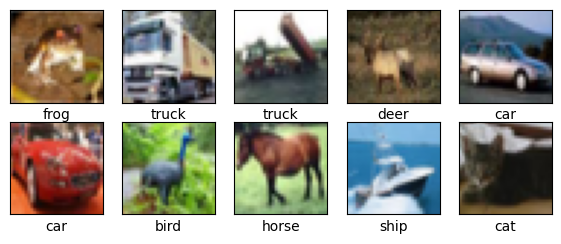

In [ ]:
# Покажемо, для загального уявлення, перщі 10 зображень з відповідними мітками з тренувальної вибірки
class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(7, 7))
for i in range(10):
    plt.subplot(5, 5, i + 1)  # визначає сітку 5x5 підзображень у великому зображенні
    plt.xticks([])  # вимикання координатних числових підписів
    plt.yticks([])
    plt.imshow(x_train[i])  # відображення картинки
    plt.xlabel(class_names[y_train[i][0]])  # підписування картинки міткою класу
plt.show()

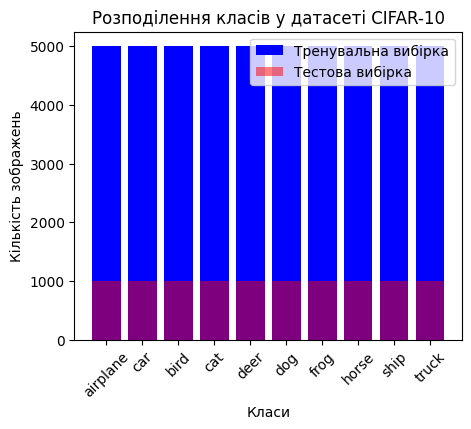

In [ ]:
# Проаналізуємо розподілення даних по класах для тренувальної та тестової вибірок
train_class_counts = np.bincount(y_train.flatten())  # кількість зображень у кожному класі для тренувальної вибірки
test_class_counts = np.bincount(y_test.flatten())  # кількість зображень у кожному класі для тестової вибірки

# Візуалізація розподілення класів
plt.figure(figsize=(5, 4))
plt.bar(np.arange(len(class_names)), train_class_counts, color='blue', label='Тренувальна вибірка')
plt.bar(np.arange(len(class_names)), test_class_counts, color='red', alpha=0.5, label='Тестова вибірка')
plt.xlabel('Класи')
plt.ylabel('Кількість зображень')
plt.title('Розподілення класів у датасеті CIFAR-10')
plt.xticks(np.arange(len(class_names)), class_names, rotation=45)
plt.legend()
plt.show()

Як видно, датасет добре збалансований.

In [3]:
# Виконаємо нормалізацію даних перед їх передачею у згорткову модель
x_train, x_test = x_train / 255., x_test / 255.

In [4]:
# Забезпечення сумісності даних CIFAR-10 з VGG16
from keras.utils import to_categorical

# Перетворення міток в категоріальний формат
train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

CIFAR-10 є невеликим датасетом, тому збільшемо обсях даних для покращання якості моделі за рахунок аугментації.

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Розділимо дані на навчальний та валідаційний набори (це знадобиться далі)
x_train, x_val, train_labels, train_labels_val = train_test_split(x_train, train_labels, test_size=0.25, random_state=42)

# Готуємо аугментацію
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


train_datagen.fit(x_train)

#### 1.2. Створення згорткової моделі

In [ ]:
from keras.optimizers import Adam

img_rows, img_cols , channels= 32,32,3
reg=None
num_filters=32
ac='relu'
adm=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt=adm
drop_dense=0.5
drop_conv=0

# Будуємо модель
model = keras.Sequential()

model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, input_shape=(img_rows, img_cols, channels), padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_conv))

model.add(Conv2D(2*num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_conv))

model.add(Conv2D(4*num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4*num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(drop_conv))

model.add(Flatten())
model.add(Dense(512, activation=ac, kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(10, activation='softmax'))

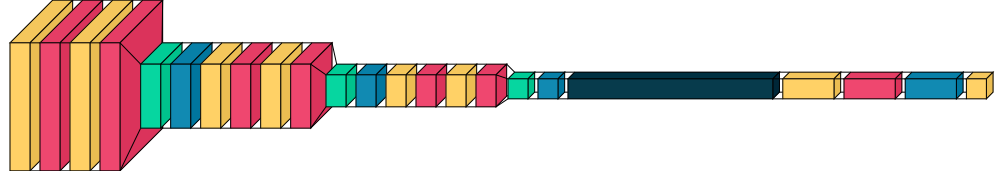

In [ ]:
# Візуалізуємо шарову структуру моделі
!pip install visualkeras

import visualkeras

visualkeras.layered_view(model)

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_16 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_17 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                      

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
    )

In [ ]:
model_name = 'model_1'

history=model.fit(train_datagen.flow(x_train, train_labels, batch_size=128),
                    steps_per_epoch = len(x_train) / 128, epochs=100, validation_data=(x_val, train_labels_val))

Epoch 1/100
86/86 [==============================] - 12s 88ms/step - loss: 2.4265 - sparse_categorical_accuracy: 0.2837 - val_loss: 3.1627 - val_sparse_categorical_accuracy: 0.1043
Epoch 2/100
86/86 [==============================] - 8s 90ms/step - loss: 1.9304 - sparse_categorical_accuracy: 0.3604 - val_loss: 2.9318 - val_sparse_categorical_accuracy: 0.1365
Epoch 3/100
86/86 [==============================] - 8s 91ms/step - loss: 1.7316 - sparse_categorical_accuracy: 0.4024 - val_loss: 3.1430 - val_sparse_categorical_accuracy: 0.1614
Epoch 4/100
86/86 [==============================] - 7s 83ms/step - loss: 1.6346 - sparse_categorical_accuracy: 0.4404 - val_loss: 3.0067 - val_sparse_categorical_accuracy: 0.1752
Epoch 5/100
86/86 [==============================] - 8s 90ms/step - loss: 1.5432 - sparse_categorical_accuracy: 0.4603 - val_loss: 2.2883 - val_sparse_categorical_accuracy: 0.2895
Epoch 6/100
86/86 [==============================] - 8s 94ms/step - loss: 1.4793 - sparse_categoric

In [ ]:
# Оцінка точності на тестових даних
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

313/313 [==============================] - 1s 4ms/step - loss: 0.8188 - sparse_categorical_accuracy: 0.7590
Test accuracy: 0.7590000033378601


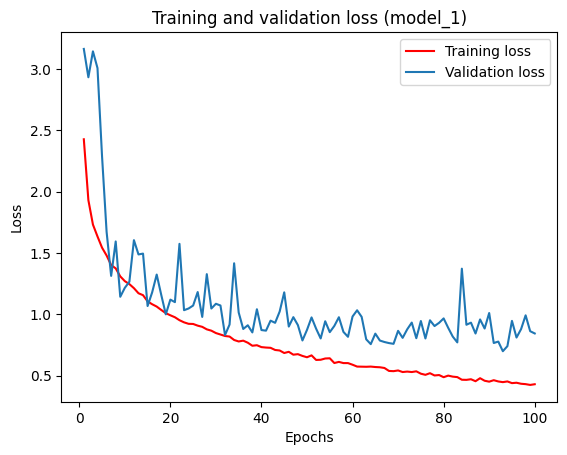

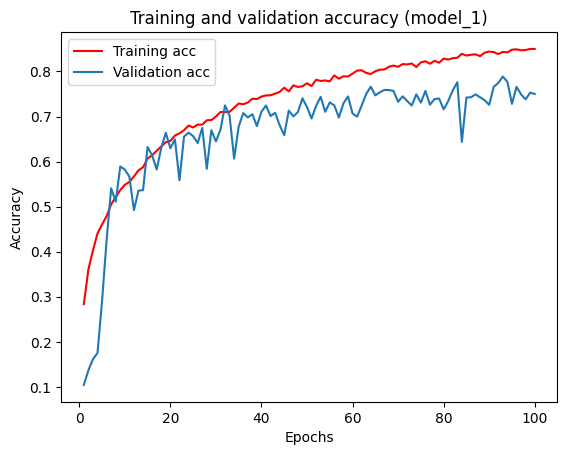

In [ ]:
# Візуалізуємо результати навчання

history_dict = history.history

epochs = range(1, len(history_dict['sparse_categorical_accuracy']) + 1)

plt.plot(epochs, history_dict['loss'], label='Training loss', color="r")
plt.plot(epochs, history_dict['val_loss'], label='Validation loss')
plt.title(f'Training and validation loss ({model_name})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
plt.plot(epochs, history_dict['sparse_categorical_accuracy'], label='Training acc', color="r")
plt.plot(epochs, history_dict['val_sparse_categorical_accuracy'], label='Validation acc')
plt.title(f'Training and validation accuracy ({model_name})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# Збереження навченої моделі
model.save("model_1_cifar10")

Точність моделі можна покращити. Для цього використаємо VGG16 в якості згорткової основи. Застосуємо прийоми донавчання та виділення ознак.

#### 1.3. Згорткова модель з попередньо навченою мережею VGG16
VGG16 очікує кольорові зображення розміром 32x32, тому для датасету CIFAR-10 не потрібно змінювати розмір вхідних даних.

#### 1.3.1. Виділення ознак (feature extraction)
Полягає в тому, щоб взяти основу попередньо навченої мережі, потім "прикріпити" до неї повнозв'язний класифікатор і навчити його на нових даних.

In [6]:
from keras.applications.vgg16 import VGG16

# Створення VGG16 без верхнього повнозв'язаного шару
conv_base = VGG16(weights='imagenet', include_top=False, classes=10, input_shape=(32, 32, 3))
# weights='imagenet': ваги моделі повинні завантажуватися з попередньо навченої моделі на наборі даних ImageNet.
# ImageNet - це великий набір даних для розпізнавання об'єктів, який включає тисячі класів.
# Ваги, навчені на ImageNet, можуть бути використані як ефективний вихідний пункт для подальших завдань.
# include_top=False: верхні (fully connected) шари моделі (які відповідають за класифікацію в тисячах класів ImageNet)
# не повинні включатися. Ми  додаватимемо свій власний классифікатор поверх цієї згорткової основи, і тому верхні шари не потрібні.
# input_shape=(32, 32, 3): розмір вхідних зображень, які використовуються.
# У цьому випадку припускається, що вхідні зображення мають розмір 32x32 пікселів і три канали (RGB).

# Заморожуємо ваги базової моделі
conv_base.trainable = False

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
# Створимо згорткову нейромережу, що використовує VGG16 як згортковий шар
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications import VGG16
from keras.optimizers import Adam


img_rows, img_cols , channels= 32,32,3
reg=None
num_filters=32
ac='relu'
adm=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt=adm
drop_dense=0.5
drop_conv=0

# Завантажуємо попередньо навчену модель VGG16 без верхнього шару
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


model = Sequential()

# Добавляємо VGG16 в послідовність
model.add(conv_base)

# Додаємо шари з попередньої моделі
model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(Dropout(drop_conv))
model.add(Conv2D(2*num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(Dropout(drop_conv))
model.add(Conv2D(4*num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4*num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(Dropout(drop_conv))
model.add(Flatten())
model.add(Dense(512, activation=ac, kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(10, activation='softmax'))


model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
    metrics=["accuracy"]
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 1, 1, 32)          147488    
                                                                 
 batch_normalization (Batch  (None, 1, 1, 32)          128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 32)          9248      
                                                                 
 batch_normalization_1 (Bat  (None, 1, 1, 32)          128       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 32)          9

In [ ]:
# Візуалізуємо шарову структуру моделі
!pip install visualkeras

import visualkeras

visualkeras.layered_view(model)

In [ ]:
model_name = 'model_2'

history=model.fit(train_datagen.flow(x_train, train_labels, batch_size=128),
                    steps_per_epoch = len(x_train) / 128, epochs=100, validation_data=(x_val, train_labels_val))

Epoch 1/100
292/292 [==============================] - 49s 124ms/step - loss: 2.9321 - accuracy: 0.1116 - val_loss: 2.3088 - val_accuracy: 0.0946
Epoch 2/100
292/292 [==============================] - 31s 105ms/step - loss: 2.6018 - accuracy: 0.1598 - val_loss: 2.5022 - val_accuracy: 0.1368
Epoch 3/100
292/292 [==============================] - 35s 118ms/step - loss: 2.3161 - accuracy: 0.2184 - val_loss: 2.1673 - val_accuracy: 0.2475
Epoch 4/100
292/292 [==============================] - 32s 110ms/step - loss: 2.0610 - accuracy: 0.2809 - val_loss: 1.8149 - val_accuracy: 0.3398
Epoch 5/100
292/292 [==============================] - 30s 101ms/step - loss: 1.8683 - accuracy: 0.3479 - val_loss: 2.5130 - val_accuracy: 0.2574
Epoch 6/100
292/292 [==============================] - 32s 109ms/step - loss: 1.7191 - accuracy: 0.3980 - val_loss: 1.4668 - val_accuracy: 0.4813
Epoch 7/100
292/292 [==============================] - 31s 107ms/step - loss: 1.5746 - accuracy: 0.4536 - val_loss: 1.8773 -

In [ ]:
# Оцінка точності на тестових даних
test_loss, test_acc = model.evaluate(x_test, test_labels)
print(f'Test accuracy: {test_acc}')

313/313 [==============================] - 4s 11ms/step - loss: 0.5271 - accuracy: 0.8452
Test accuracy: 0.8452000021934509


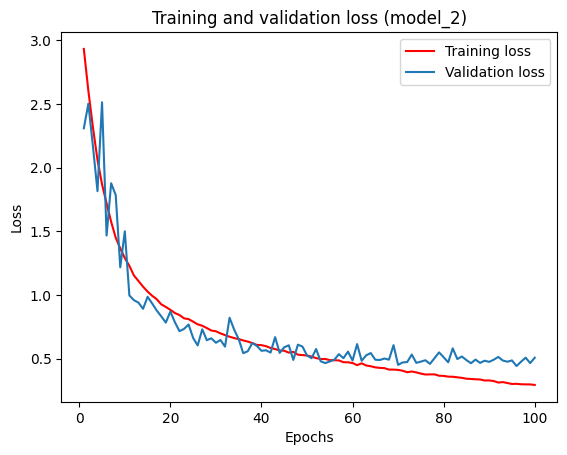

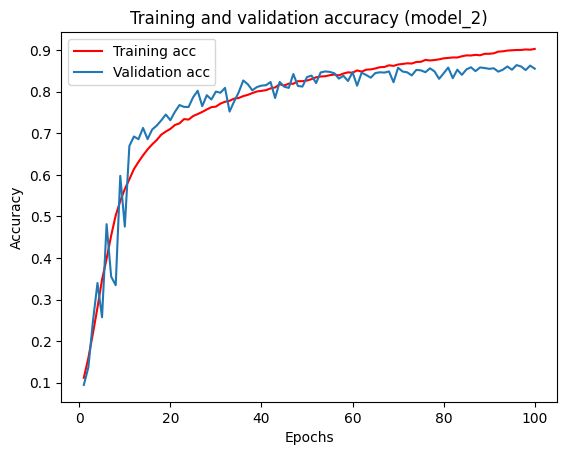

In [ ]:
# Візуалізуємо результати навчання
history_dict = history.history

epochs = range(1, len(history_dict['loss']) + 1)

plt.plot(epochs, history_dict['loss'], label='Training loss', color="r")
plt.plot(epochs, history_dict['val_loss'], label='Validation loss')
plt.title(f'Training and validation loss ({model_name})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
plt.plot(epochs, history_dict['accuracy'], label='Training acc', color="r")
plt.plot(epochs, history_dict['val_accuracy'], label='Validation acc')
plt.title(f'Training and validation accuracy ({model_name})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
# Збереження навченої моделі
model.save("model_2_cifar10")

#### 1.3.2. Донавчання нейромережі з основою VGG16
Цей підхід полягає в "розморожуванні" декількох верхніх шарів замороженої моделі, яка використовувалася для виділення ознак, і спільному навчанні нової доданої частини моделі (в даному випадку повнозв'язкового класифікатора) і цих верхніх шарів.

Для донавчання мережі потрібно виконати такі кроки:

- додати свою мережу поверх навченої базової мережі;
- заморозити базову мережу;
- навчити додану частину;
- розморозити кілька шарів у базовій мережі;
- навчити ці шари та додану частину разом.

Ми вже виконали перші три кроки, коли виділяли ознаки. Тепер виконаємо четвертий крок розморозивши кілька шарів у conv_base.

In [7]:
# Подивимося архітектуру нашої згорткової основи
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [8]:
# Виконаємо розморожування для донавчання останніх трьох шарів, а саме: block5_conv1, block5_conv2 та block5_conv3.
# Інші шари залишимо замороженими.
conv_base.trainable = True  # всі шари (layers) моделі conv_base тепер можна тренувати
set_trainable = False  # встановлює початкове значення змінної, яка буде використовуватися для визначення того, чи ми повинні тренувати певний шар
for layer in conv_base.layers:  # перебирає всі шари в моделі conv_base
    if layer.name == "block5_conv1":
        set_trainable = True  # якщо поточний шар має ім'я "block5_conv1", то встановлює змінну set_trainable в значення True (це означає, що всі наступні шари будуть тренуватися)
    if set_trainable:
        layer.trainable = True  # встановлюється можливість тренування для поточного шару
    else:
        layer.trainable = False  # поточний шар "заморожується"

In [9]:
# Створимо згорткову нейромережу, що використовує VGG16 як згортковий шар
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications import VGG16
from keras.optimizers import Adam


img_rows, img_cols , channels= 32,32,3
reg=None
num_filters=32
ac='relu'
adm=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
opt=adm
drop_dense=0.5
drop_conv=0

# Завантажуємо попередньо навчену модель VGG16 без верхнього шару
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


model = Sequential()

# Добавляємо VGG16 в послідовність
model.add(conv_base)

# Додаємо шари з попередньої моделі
model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(Dropout(drop_conv))
model.add(Conv2D(2*num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(2*num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(Dropout(drop_conv))
model.add(Conv2D(4*num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(4*num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(num_filters, (3, 3), activation=ac, kernel_regularizer=reg, padding='same'))
model.add(Dropout(drop_conv))
model.add(Flatten())
model.add(Dense(512, activation=ac, kernel_regularizer=reg))
model.add(BatchNormalization())
model.add(Dropout(drop_dense))
model.add(Dense(10, activation='softmax'))


model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
    metrics=["accuracy"]
)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 1, 1, 32)          147488    
                                                                 
 batch_normalization (Batch  (None, 1, 1, 32)          128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 32)          9248      
                                                                 
 batch_normalization_1 (Bat  (None, 1, 1, 32)          128       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 32)          9

In [ ]:
# Візуалізуємо шарову структуру моделі
!pip install visualkeras

import visualkeras

visualkeras.layered_view(model)

In [11]:
model_name = 'model_3'

history=model.fit(train_datagen.flow(x_train, train_labels, batch_size=128),
                    steps_per_epoch = len(x_train) / 128, epochs=100, validation_data=(x_val, train_labels_val))

Epoch 1/100
292/292 [==============================] - 61s 148ms/step - loss: 2.8993 - accuracy: 0.1266 - val_loss: 2.3160 - val_accuracy: 0.0946
Epoch 2/100
292/292 [==============================] - 33s 112ms/step - loss: 2.6454 - accuracy: 0.1552 - val_loss: 2.1347 - val_accuracy: 0.1709
Epoch 3/100
292/292 [==============================] - 49s 166ms/step - loss: 2.5409 - accuracy: 0.1653 - val_loss: 2.7293 - val_accuracy: 0.1490
Epoch 4/100
292/292 [==============================] - 46s 156ms/step - loss: 2.3460 - accuracy: 0.2042 - val_loss: 2.8197 - val_accuracy: 0.1618
Epoch 5/100
292/292 [==============================] - 41s 139ms/step - loss: 2.1464 - accuracy: 0.2563 - val_loss: 2.1407 - val_accuracy: 0.2726
Epoch 6/100
292/292 [==============================] - 39s 134ms/step - loss: 1.9037 - accuracy: 0.3272 - val_loss: 2.0450 - val_accuracy: 0.2882
Epoch 7/100
292/292 [==============================] - 32s 108ms/step - loss: 1.7182 - accuracy: 0.3919 - val_loss: 1.4371 -

In [12]:
# Оцінка точності на тестових даних
test_loss, test_acc = model.evaluate(x_test, test_labels)
print(f'Test accuracy: {test_acc}')

313/313 [==============================] - 4s 11ms/step - loss: 0.4760 - accuracy: 0.8557
Test accuracy: 0.8557000160217285


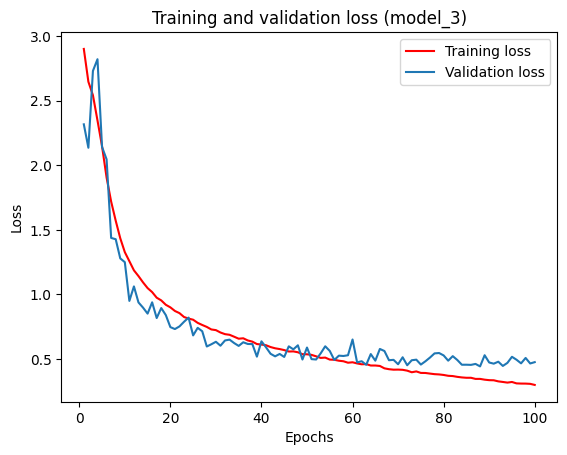

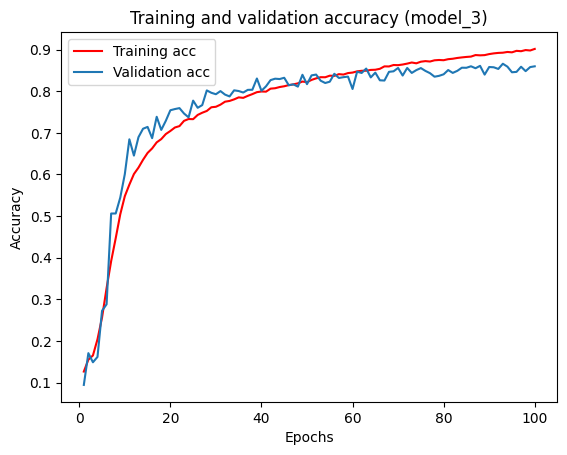

In [13]:
# Візуалізуємо результати навчання
history_dict = history.history

epochs = range(1, len(history_dict['loss']) + 1)

plt.plot(epochs, history_dict['loss'], label='Training loss', color="r")
plt.plot(epochs, history_dict['val_loss'], label='Validation loss')
plt.title(f'Training and validation loss ({model_name})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()
plt.plot(epochs, history_dict['accuracy'], label='Training acc', color="r")
plt.plot(epochs, history_dict['val_accuracy'], label='Validation acc')
plt.title(f'Training and validation accuracy ({model_name})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [14]:
# Збереження навченої моделі, пропишемо скрипт для збереження моделы на Google Drive, а не в середовищі (бо після закінчення сеансу вона зникне)

from google.colab import drive

# Монтуємо Google Drive
drive.mount('/content/drive')

# Шлях для збереження моделі
save_path = '/content/drive/My Drive/model_3_cifar10'

# Сохраняем модель
model.save(save_path)

Mounted at /content/drive


Наведемо Confusion Matrix для розуміння якості моделі по різних класах.

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

# Завантаження попередньо навченої моделі
from keras.models import load_model
model = load_model('/content/drive/MyDrive/model_3_cifar10')

# Отримання прогнозованих класів для тестового набору
y_pred_prob = model.predict(x_test)  # вирогідності приналежності до кожного класа для кожного тестового зразка
y_pred = np.argmax(y_pred_prob, axis=1) # прогнозні мітки класів

313/313 [==============================] - 3s 8ms/step


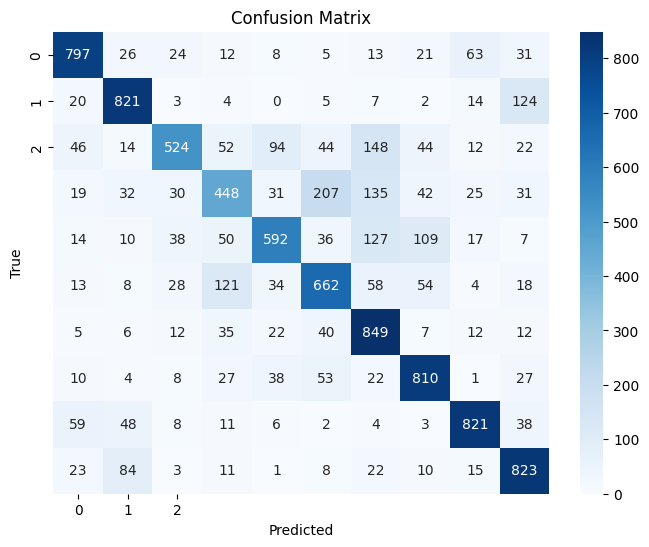

In [ ]:
# Побудова Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(test_labels, axis=1), y_pred)

# Візуалізація Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Отримання і вивід іншої важливої інформації
print("\nClassification Report:")
print(classification_report(np.argmax(test_labels, axis=1), y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1000
           1       0.78      0.82      0.80      1000
           2       0.77      0.52      0.62      1000
           3       0.58      0.45      0.51      1000
           4       0.72      0.59      0.65      1000
           5       0.62      0.66      0.64      1000
           6       0.61      0.85      0.71      1000
           7       0.74      0.81      0.77      1000
           8       0.83      0.82      0.83      1000
           9       0.73      0.82      0.77      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000



# Висновки
Метою даної роботи є створення навченої на датасеты CIFAR-10 моделі для класифікації зображень. Так як датасет невеликий, для покращання навчання застосовано аугментацію. Тренувальні дані поділено на дві частини: навчальну та валідаційну. Кількість епох навчання для всіх варіантів моделей - 100.

На першому етапі створено згорткову глубоку нейромережу. Її точність склала 75,9%.

На другому етапі використано переднавчену модель VGG16, із замороженими шарами, в якості базового шару. Після базового йшли шари, аналогічні першій моделі. Точність склала 84,5%.

На сам кінець застосовано модель, аналогічну другій, але в базовому шарі розморожено та донавчено три останні шари. Точність склала 85,6%. Цю модель збережено.

Проаналізуємо кінцевий Classification Report.

Precision (точність): це міра того, наскільки точними є передбачення моделі конкретного класу. Вона показує, яка частка зображень, які класифікувала модель як певний клас, дійсно належать цьому класу. Наприклад, для класу 0 точність становить 0.79, що означає, що 79% зображень, які модель передбачила як клас 0, дійсно були класом 0.

Recall (повнота): це міра того, як добре модель виявляє всі зразки даного класу. Вона показує, яка частка всіх зображень даного класу була коректно виявлена моделлю. Наприклад, для класу 0 повнота становить 0.80, що означає, що модель виявила 80% всіх зображень, які дійсно належать класу 0.

F1-score (F-міра): це середнє гармонійне між точністю та повнотою. Він використовується для оцінки балансу між точністю та повнотою.

Support: це кількість зразків у кожному класі у тестовому наборі даних.

Accuracy (точність): Це відношення числа правильно класифікованих зразків до всіх зразків тестового набору. У цьому випадку accuracy становить 0.71, що означає, що модель правильно класифікувала 71% всіх зображень тестового набору даних.

Загальний висновок з цього Classification Report для CIFAR-10 полягає в тому, що модель має прийнятну точність і повноту для деяких класів, але може бути менш ефективною для інших класів. Наприклад, модель добре передбачає класи 0, 1, 6, 7, 8 і 9, але менш точна для класів 2, 3, 4 і 5.